In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  datetime import datetime, timedelta
import time
import gc
from pmdarima import auto_arima
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [5]:
# helper functions to reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [4]:
pd.options.display.max_columns = 50

In [5]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [6]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    ##########################################################################################
    #Remember to change this into 'sales_train_evaluation' before submitting the final prediction
    dt = pd.read_csv("sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    ############################################################################################
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [7]:
def create_fea(dt):
    lags = [7,14,21,28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    #Windows
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [8]:
FIRST_DAY = 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [36]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

Wall time: 28.2 s


(40718219, 22)

In [37]:
df['d'] = df['d'].str.slice(2)
df['d'] = df['d'].astype('int16')
df = reduce_mem_usage(df)

Mem. usage decreased to 2058.09 Mb (28.4% reduction)


In [38]:
%%time

create_fea(df)
df.shape

Wall time: 5min 29s


(40718219, 37)

In [39]:
df.dropna(inplace = True)
df.shape

(39041269, 37)

## Auto-ARIMA

In [9]:
#Let's inspect one record for illustration purpose
ts_df = pd.read_csv('sales_train_validation.csv')

In [10]:
base = datetime(2011,1,29)
date_col = [col for col in ts_df if col.startswith('d_')]

In [11]:
#Experiment 1
record = ts_df.loc[np.random.randint(df.shape[1])]
record_df = record.to_frame().T
record_datum = pd.DataFrame(record_df[date_col].sum(axis =0),columns = ["sales"])
record_datum['datum'] = [base + timedelta(days=x) for x in range(1913)]

NameError: name 'df' is not defined

In [172]:
#Experiment 2
#State-wise sales data
state_lvl = ts_df.groupby("state_id")[date_col].sum().reset_index().set_index('state_id').T
state_lvl['datum'] = [base + timedelta(days=x) for x in range(1913)]
state_lvl.set_index('datum', inplace=True)
state_lvl

state_id,CA,TX,WI
datum,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


#### Here are two different ways to plot this single time series record

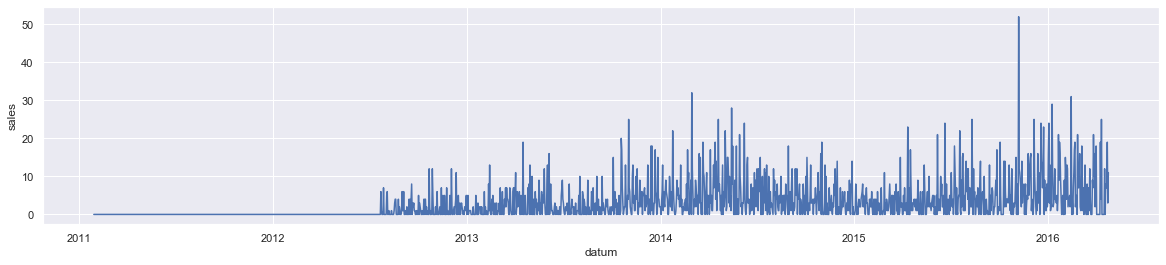

In [622]:
sns.set(rc={'figure.figsize':(20,4)})
sns.lineplot(x="datum", y="sales", data=record_datum)
plt.show()

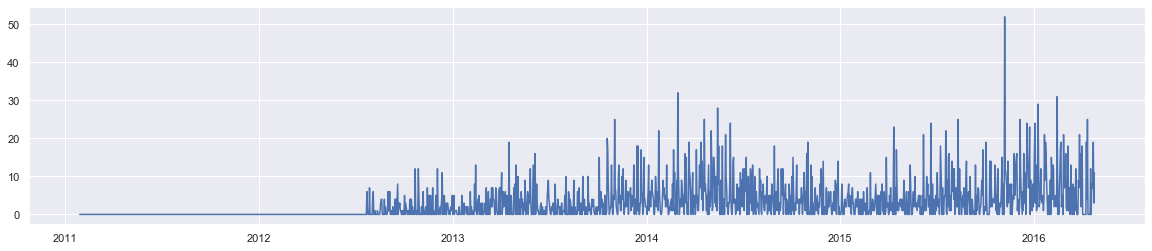

In [639]:
record_datum_ind = record_datum.set_index('datum')
fig = plt.figure()
plt.plot(record_datum_ind)
plt.show()

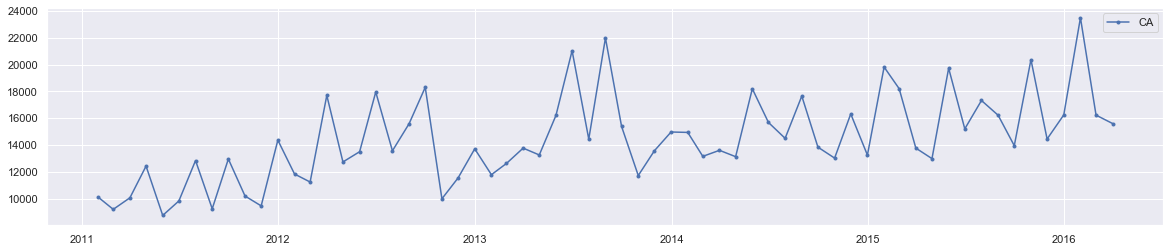

In [196]:
#Time series plot over three states
plt.figure(figsize=(20,4))
plt.plot(state_lvl.asfreq('M').CA, marker='.',label='CA')
plt.legend()
plt.show()

#### Now let's take a closer look at the tail

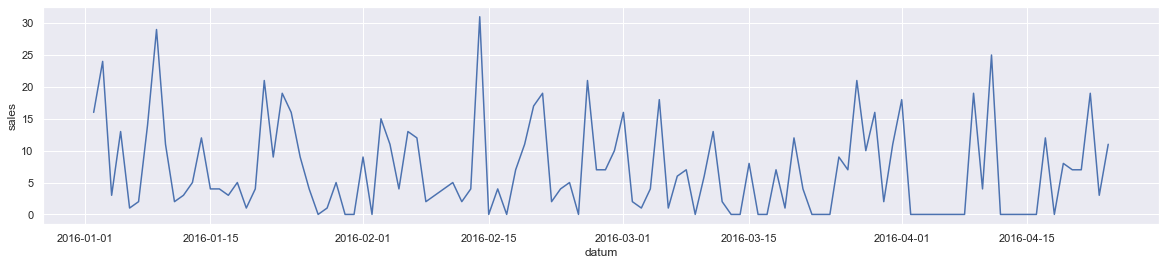

In [625]:
sns.set(rc={'figure.figsize':(20,4)})
sns.lineplot(x="datum", y="sales", data=record_datum.loc[record_datum['datum'] > '2016-01-01'])
plt.show()

#### We then opt out the last 28 days as validation set

In [684]:
record_train = record_datum[:-28]
record_validation = record_datum[-28:]
record_train.set_index('datum',inplace=True)
record_validation.set_index('datum',inplace=True)
# record_train = state_lvl.CA.to_frame()
# record_train.rename(columns={'CA':'sales'},inplace=True)
# record_validation = state_lvl[-300:].CA.to_frame()
# record_validation.rename(columns={'CA':'sales'},inplace=True)

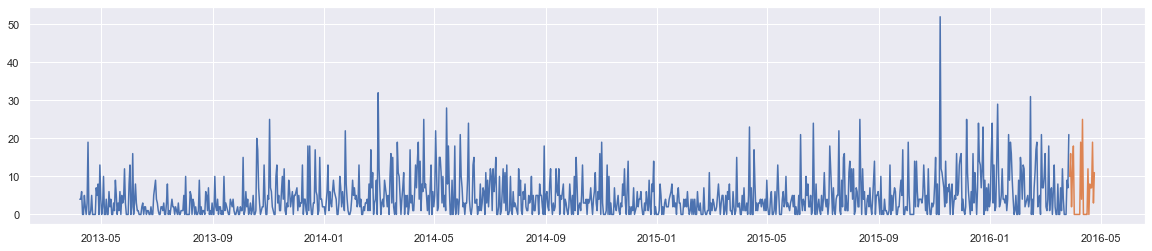

In [686]:
plt.plot(record_train[800:])
plt.plot(record_validation)
plt.show()

In [687]:
t0 = time.time()
arima_model = auto_arima(record_train[800:]['sales'], trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
arima_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=6725.262, BIC=6755.193, Time=0.813 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7375.203, BIC=7385.180, Time=0.020 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=7103.843, BIC=7118.808, Time=0.067 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6685.658, BIC=6700.623, Time=0.165 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=7373.208, BIC=7378.196, Time=0.024 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6687.068, BIC=6707.022, Time=0.297 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=6687.034, BIC=6706.987, Time=0.240 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=6689.577, BIC=6714.519, Time=0.320 seconds
Total fit time: 1.953 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1085
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3339.829
Date:                Thu, 25 Jun 2020   AIC                           6685.658
Time:                        16:21:51   BIC                           6700.623
Sample:                             0   HQIC                          6691.324
                               - 1085                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0034      0.006      0.566      0.571      -0.008       0.015
ma.L1         -0.9732      0.008   -126.722      0.000      -0.988      -0.958
sigma2        27.7006      0.686     40.400      0.000      26.357      29.044
===================================================================================
Ljung-Box (Q):                      223.15   Jarque-Bera (JB):              4148.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [689]:
arima_model.fit(record_train[800:]['sales'])

ARIMA(order=(0, 1, 1), suppress_warnings=True)

In [690]:
arima_model.predict(n_periods=28)

array([6.61121828, 6.6145739 , 6.61792952, 6.62128514, 6.62464077,
       6.62799639, 6.63135201, 6.63470763, 6.63806325, 6.64141887,
       6.64477449, 6.64813011, 6.65148573, 6.65484135, 6.65819698,
       6.6615526 , 6.66490822, 6.66826384, 6.67161946, 6.67497508,
       6.6783307 , 6.68168632, 6.68504194, 6.68839756, 6.69175319,
       6.69510881, 6.69846443, 6.70182005])

In [691]:
record_validation

,sales
datum,
2016-03-28,10.0
2016-03-29,16.0
2016-03-30,2.0
2016-03-31,11.0
2016-04-01,18.0
2016-04-02,0.0
2016-04-03,0.0
2016-04-04,0.0
2016-04-05,0.0


In [680]:
record_pred = pd.DataFrame()
record_pred['datum'] = record_datum['datum'][-300:]
record_pred['pred'] = arima_model.predict(n_periods=300)
record_pred

,datum,pred
d_1614,2015-06-30,18624.844407
d_1615,2015-07-01,16462.419910
d_1616,2015-07-02,16042.695775
d_1617,2015-07-03,15339.426377
d_1618,2015-07-04,17300.592095
...,...,...
d_1909,2016-04-20,20590.879465
d_1910,2016-04-21,20499.213119
d_1911,2016-04-22,20481.057607
d_1912,2016-04-23,20590.402793


In [682]:
#Evaluation
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(record_pred['pred'], record_validation['sales'][-300:]))
print('RMSE for {}: {:.4f}'.format(model_name,score))

RMSE for ARIMA: 3909.1221


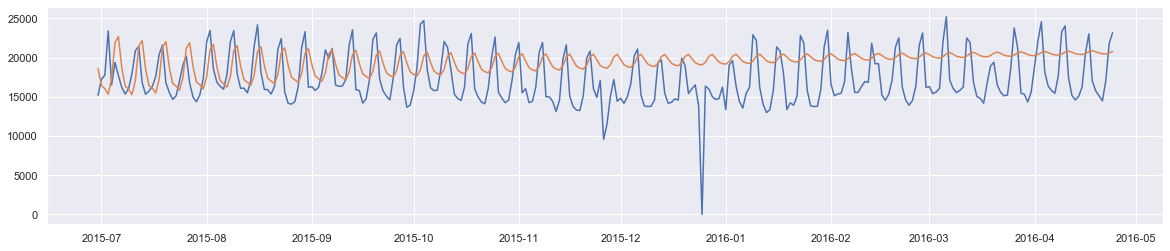

In [683]:
plt.plot(record_validation)
record_pred_ind = record_pred.set_index('datum')
plt.plot(record_pred_ind)

In [675]:
record_datum_ind = record_datum.set_index('datum')
record_pred_ind = record_pred.set_index('Datum')

state_lvl_ind = state_lvl.CA.to_frame()

fig = plt.figure()
plt.plot(state_lvl_ind[-400:])
plt.plot(record_pred_ind[-400:])
plt.show()

KeyError: "None of ['Datum'] are in the columns"

## ANN

In [257]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [267]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
import tensorflow as tf

In [272]:
train = state_lvl[state_lvl.index < split_date].CA
test = state_lvl[state_lvl.index >= split_date].CA

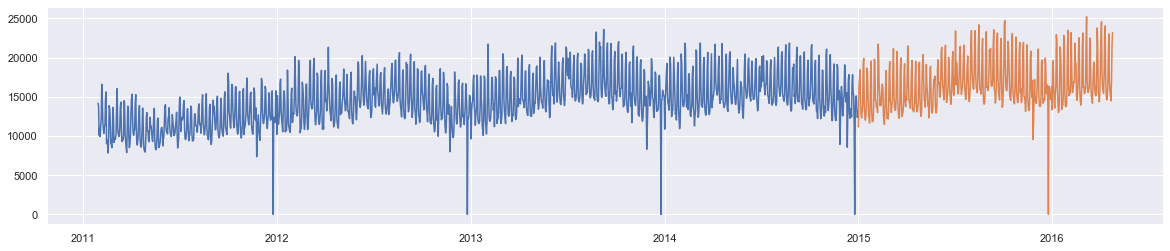

In [275]:
split_date = datetime(2015,1,1)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(train)
ax.plot(test)
plt.show()

In [248]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [253]:
predict_days = 1
X_train = train_sc[:-predict_days]
y_train = train_sc[predict_days:]
 
X_test = test_sc[:-predict_days]
y_test = test_sc[predict_days:]

In [276]:
nn = Sequential()
nn.add(Dense(50,input_dim=1,activation='relu'))
nn.add(Dense(1))
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [277]:
nn.compile(loss='mae',optimizer='adam')
early_stop = EarlyStopping(monitor='loss',patience=2, verbose=1)
history = nn.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1,callbacks=[early_stop],shuffle=False)

Epoch 1/100
47/47 [==============================] - 0s 9ms/step - loss: 0.3820
Epoch 2/100
47/47 [==============================] - 0s 658us/step - loss: 0.3313
Epoch 3/100
47/47 [==============================] - 0s 552us/step - loss: 0.3216
Epoch 4/100
47/47 [==============================] - 0s 657us/step - loss: 0.3195
Epoch 5/100
47/47 [==============================] - 0s 594us/step - loss: 0.3185
Epoch 6/100
47/47 [==============================] - 0s 594us/step - loss: 0.3150
Epoch 7/100
47/47 [==============================] - 0s 577us/step - loss: 0.3166
Epoch 8/100
47/47 [==============================] - 0s 616us/step - loss: 0.3158
Epoch 00008: early stopping


In [279]:
history.history

{'loss': [0.382001538542991,
  0.3313285990598354,
  0.3216152497111483,
  0.3195331037995663,
  0.31852894878767907,
  0.3149965484725668,
  0.31658385170901077,
  0.3157979777835785]}

In [280]:
y_pred_test_nn = nn.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Test set is:	-0.770


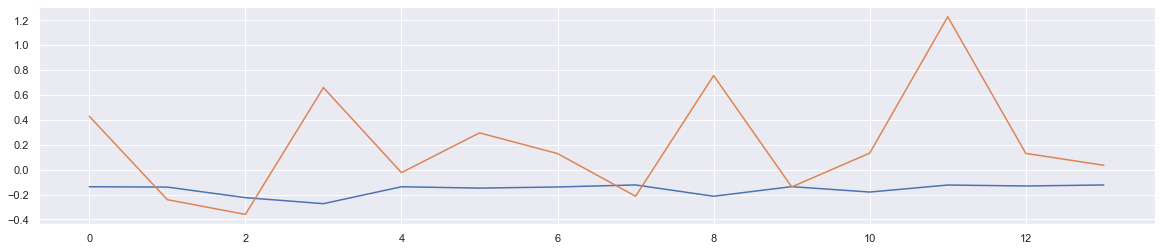

In [281]:
plt.plot(y_pred_test_nn)
plt.plot(y_test)

# ANN experiment

## Linear part prediction

In [6]:
def CreateTimeSeries(dept_id, store_id):
    item_series =  df_sale_group_item[(df_sale_group_item.dept_id == dept_id) & (df_sale_group_item.store_id == store_id)]
    dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
    dates['y'] = item_series[date_columns].values[0].transpose()     
    return dates

In [7]:
df_sale = pd.read_csv('sales_train_validation.csv')
df_sale_eval = pd.read_csv('sales_train_evaluation/sales_train_evaluation.csv')
df_calendar = pd.read_csv('calendar.csv')
df_price = pd.read_csv('sell_prices.csv')

In [8]:
date_columns = df_sale.columns[df_sale.columns.str.contains("d_")]
dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]

df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': df_calendar[~df_calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': df_calendar[~df_calendar['event_name_2'].isna()]['date']})
df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': df_calendar[df_calendar['snap_CA'] == 1]['date']})
df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': df_calendar[df_calendar['snap_TX'] == 1]['date']})
df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': df_calendar[df_calendar['snap_WI'] == 1]['date']})
holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

df_sale_group_item = df_sale[np.hstack([['dept_id','store_id'],date_columns])].groupby(['dept_id','store_id']).sum()
df_sale_group_item = df_sale_group_item.reset_index()

In [9]:
#This df regroups the items according to its departmentand store
df_sale_group_item

,dept_id,store_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1,CA_1,297,284,214,175,182,191,224,263,...,293,317,268,302,237,287,297,331,419,329
1,FOODS_1,CA_2,406,408,238,240,220,263,304,353,...,535,504,515,327,366,422,334,579,623,520
2,FOODS_1,CA_3,341,326,260,231,220,258,285,309,...,420,500,457,301,331,306,276,335,510,423
3,FOODS_1,CA_4,113,124,75,97,107,84,100,111,...,284,241,193,196,185,201,190,229,250,257
4,FOODS_1,TX_1,152,154,109,126,108,153,72,126,...,204,244,245,193,138,176,198,201,218,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,HOUSEHOLD_2,TX_2,199,183,117,108,98,110,133,200,...,210,246,270,134,193,182,187,211,260,244
66,HOUSEHOLD_2,TX_3,120,138,97,83,46,102,120,141,...,198,218,201,127,189,158,161,131,185,191
67,HOUSEHOLD_2,WI_1,148,151,66,47,0,105,126,186,...,196,225,199,143,131,158,169,192,203,224
68,HOUSEHOLD_2,WI_2,98,94,69,80,32,107,100,111,...,136,138,137,139,147,113,127,160,194,177


In [337]:
prophet_output = [['FOODS_1', 'CA_1', '1633', '391.719547767208', '386.5092939026144',
        '389.53035053371536', '405.3243068734415', '484.36687564826394',
        '559.03451454901', '494.87249330774523', '399.84195534760823',
        '392.4195594352015', '393.2976116177725', '407.08040182200267',
        '484.47309640790536', '568.0892680989847', '498.59657531612373',
        '407.6702665312845', '391.0542202041521', '399.18314462826237',
        '412.45879625217043', '487.5696658513328', '557.441057579257',
        '497.2521246437795', '392.5036134842601', '387.97439150132465',
        '388.8079384978504', '400.7491732312306', '475.8566075229754',
        '556.3860875339774', '483.03179644117074'],
 ['FOODS_1', 'CA_1', '1661', '334.2232816242748',
        '328.0628919695163', '330.4802122800395', '343.4840380889727',
        '417.0816306604058', '484.99471999558756', '425.3454439330318',
        '337.4747009112798', '330.791555696017', '332.4717034866154',
        '344.5435963991756', '417.097326401124', '483.8039056529777',
        '422.67294430167937', '333.2003628394378', '335.5781424833444',
        '332.0592687213935', '347.95812828509065', '412.1491937039479',
        '484.6132173271328', '422.22738981233834', '316.31486228411416',
        '317.2689223741227', '322.16321899464236', '325.40211505966926',
        '398.3265712409222', '464.03555196840387', '400.3194062454151'],
 ['FOODS_1', 'CA_1', '1689', '266.1766758023649',
        '263.0763891903004', '257.50113548464975', '267.1013199111619',
        '332.10830807518687', '392.4734585371366', '338.1352848810573',
        '258.6780676655084', '251.81249487746823', '253.58734749614982',
        '253.17109634062462', '330.1832576262726', '391.31502147802206',
        '337.91140295628804', '259.30472231238684', '252.93609052232708',
        '255.01866725538108', '275.5154690987047', '337.27215686634986',
        '403.0763836580077', '343.40018443296384', '270.6492750799138',
        '263.74096942962194', '264.0891310201378', '270.2669859908052',
        '340.0276413713947', '393.81101119610923', '341.05972209764394'],
 ['FOODS_1', 'CA_1', '1717', '247.41308736670553',
        '247.80738027808115', '244.30268253171823', '258.65473764567764',
        '313.4131054619487', '369.78666142630294', '316.9165862289804',
        '240.52376327914413', '232.5425672839', '232.11050496106682',
        '241.73515892308112', '302.8491926058595', '359.1825101930629',
        '306.75900223481887', '230.92002102975343', '223.19356390047622',
        '222.95251456482424', '232.67594395916842', '293.60691052578807',
        '339.80266733008386', '306.49307106328257', '227.7532321303654',
        '224.50474073776388', '217.5252230729693', '233.17463888667075',
        '293.3754493461478', '347.05382640745853', '291.4498768334553'],
 ['FOODS_1', 'CA_1', '1745', '208.79899226518896',
        '194.8753825488912', '186.90069911398567', '204.4123914330459',
        '260.61973924831204', '310.6575681857886', '264.4175525493882',
        '186.82870800889327', '179.5373946385885', '179.90755174316598',
        '189.7836635940922', '248.88873636490786', '303.6989706821887',
        '256.0457015211563', '187.23631733987654', '183.02293952816908',
        '186.64319199330237', '190.8297948574494', '262.1938667289511',
        '320.3050582745026', '276.5931787116343', '211.80906534895186',
        '218.67825030612545', '222.74936659171283', '243.14154196586486',
        '302.35447487798035', '367.9715799382687', '326.4925816332259'],
 ['FOODS_1', 'CA_1', '1773', '258.48533051994224',
        '256.02253628577205', '267.1351354600359', '276.04366042568626',
        '339.96903436145953', '397.3220080691051', '353.5243514236689',
        '278.00872883787446', '288.5690247845427', '286.4798861638029',
        '297.1606895400951', '353.96706853138215', '406.376191000047',
        '359.532407167871', '291.12588483668077', '283.46039814603853',
        '281.7935655187591', '287.25962066083633', '329.80773862739653',
        '385.86199650882065', '334.8328160735982', '262.7545994163346',
        '251.39977744744053', '246.4825711068051', '249.17960099917929',
        '296.45699661301313', '347.874562364356', '300.3819869087452'],
 ['FOODS_1', 'CA_1', '1801', '231.79457648107424',
        '225.5672180450746', '220.80699881906108', '211.99834990796484',
        '270.2216246558806', '324.79263280000873', '269.799480454085',
        '203.63211751244253', '196.95866270064786', '196.08185052858477',
        '203.2390589632425', '261.27420693909215', '311.5565988136751',
        '267.5585747455331', '191.92659970990832', '202.21226756089604',
        '207.19968762960164', '221.2427882207188', '278.6365391513553',
        '337.1511131870736', '296.1430288242663', '235.08479782171915',
        '234.96694009669767', '240.95183783265045', '255.37054440410313',
        '312.3191714070311', '369.8533773792699', '327.98787396934074'],
 ['FOODS_1', 'CA_1', '1829', '288.7228347066812', '282.242190077737',
        '289.98714208558266', '296.452371109456', '357.6739985526503',
        '414.4927964522806', '353.5293738187306', '295.06147803158865',
        '292.14148560063023', '274.50287420011097', '299.5653193627798',
        '351.84068561778724', '403.97208026526494', '339.3829893004638',
        '272.93597320905053', '270.3434488212252', '256.1976186493408',
        '275.4753173831179', '325.82680398535837', '377.77311198741506',
        '327.29198311642324', '256.20684785385265', '246.26624227740527',
        '244.18170663008613', '251.0250300098427', '301.3727526192615',
        '353.5766712189196', '304.10939407523637'],
 ['FOODS_1', 'CA_1', '1857', '238.98680086015355',
        '235.52664805291573', '232.25148598044953', '245.7103757527523',
        '292.16170248598286', '353.3231576831932', '304.991187773878',
        '235.1413494733494', '226.11026060511622', '232.68576921350794',
        '238.0377146713302', '298.6832463961314', '356.04825342152117',
        '308.8650393065027', '241.2099933721215', '241.90579376464757',
        '240.1050525154729', '240.87209738800647', '311.07543377268115',
        '369.9291884517318', '326.24661420155144', '262.67376996197885',
        '259.71749666167347', '264.6392849420417', '265.4747920634541',
        '335.0513589055725', '392.95291674347584', '335.41444993204647']]

valid = ['FOODS_1', 'CA_1', '1885', '317.8514357041766', '312.34539934242',
        '314.75987267326246', '327.1029684004763', '390.001232629461',
        '447.2782617130806', '400.1657249440027', '321.328265483289',
        '318.94170899382664', '317.9603962520329', '324.8757397676145',
        '376.60844250752746', '437.542179357496', '376.88357974307814',
        '307.71325858170366', '296.7273983504205', '291.92919014436313',
        '297.2629775731872', '354.69137459647834', '404.07248379731914',
        '349.97717371000294', '275.92026467704983', '265.7133033216391',
        '264.15326899902243', '273.2901701154006', '328.0056556392478',
        '385.8660239275554', '334.23392229595134']

In [339]:
residuals = []
for j in range(9):
    print(len(prophet_output[j]))
    first_day = int(prophet_output[j][2])
    for i in range(28):
        col_name = f'd_{first_day + i}'
#         if (i + 3) <= 28:
        pred_val = int(prophet_output[j][i+3][0:3])
        resid = pred_val - df_sale_group_item.loc[0,col_name]
        residuals.append(resid)

31
31
31
31
31
31
31
31
31


In [340]:
residuals

[35,
 88,
 41,
 31,
 137,
 175,
 169,
 42,
 66,
 134,
 114,
 130,
 112,
 27,
 1,
 49,
 22,
 14,
 153,
 97,
 -1,
 5,
 62,
 102,
 70,
 164,
 202,
 118,
 -1,
 60,
 66,
 54,
 112,
 140,
 49,
 -66,
 55,
 71,
 50,
 161,
 164,
 -11,
 4,
 64,
 55,
 27,
 94,
 89,
 11,
 -29,
 -48,
 71,
 89,
 150,
 190,
 62,
 -79,
 -64,
 -69,
 78,
 60,
 55,
 32,
 -60,
 3,
 -15,
 -13,
 9,
 78,
 -50,
 -40,
 -29,
 3,
 34,
 53,
 51,
 -81,
 -110,
 -46,
 7,
 13,
 40,
 53,
 -11,
 -46,
 15,
 7,
 29,
 88,
 85,
 -21,
 -76,
 -31,
 43,
 26,
 95,
 62,
 -56,
 -123,
 0,
 -20,
 -6,
 4,
 -66,
 -52,
 47,
 80,
 55,
 51,
 99,
 140,
 -61,
 -68,
 0,
 -16,
 -60,
 73,
 76,
 -40,
 -145,
 -24,
 -45,
 -41,
 3,
 102,
 -70,
 -96,
 -113,
 -95,
 -52,
 126,
 74,
 41,
 25,
 21,
 -42,
 -13,
 20,
 114,
 -41,
 -83,
 -82,
 -32,
 52,
 92,
 90,
 -93,
 -89,
 -69,
 -87,
 -90,
 -136,
 4,
 -149,
 -183,
 -159,
 -245,
 -286,
 -264,
 385,
 60,
 12,
 51,
 -29,
 12,
 51,
 97,
 29,
 -13,
 -73,
 33,
 -4,
 59,
 29,
 -114,
 -91,
 -122,
 -40,
 -55,
 -12,
 -19,
 -18

In [348]:
#Create prediction dataset
resid_df = pd.DataFrame(columns={'d'})
resid_df1 = pd.DataFrame(columns={'resid'})
resid_df['d'] = [f"d_{i}" for i in range(1634,1914)]
resid_df1['resid'] = residuals
final_df = pd.concat([resid_df,resid_df1],axis=1)
init_day_1634 = datetime(2015,7,20)
final_df['date'] = [init_day_1634 + timedelta(days=i) for i in range(280)]

In [349]:
final_df

,d,resid,date
0,d_1634,35.0,2015-07-20
1,d_1635,88.0,2015-07-21
2,d_1636,41.0,2015-07-22
3,d_1637,31.0,2015-07-23
4,d_1638,137.0,2015-07-24
...,...,...,...
275,d_1909,NaN,2016-04-20
276,d_1910,NaN,2016-04-21
277,d_1911,NaN,2016-04-22
278,d_1912,NaN,2016-04-23


In [350]:
#Create lags and rolling features
lags = [7,14,28]
for i in lags:
    final_df[f'lag_{i}'] = final_df['resid'].shift(i)
windows = [7, 14, 28]
for win in windows :
    for lag in lags:
        final_df[f"rmean_{lag}_{win}"] = final_df[f'lag_{lag}'].transform(lambda x : x.rolling(win).mean())
final_df

,d,resid,date,lag_7,lag_14,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_14,rmean_14_14,rmean_28_14,rmean_7_28,rmean_14_28,rmean_28_28
0,d_1634,35.0,2015-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d_1635,88.0,2015-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d_1636,41.0,2015-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,d_1637,31.0,2015-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d_1638,137.0,2015-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,d_1909,NaN,2016-04-20,NaN,NaN,-94.0,NaN,NaN,-32.000000,NaN,NaN,-31.928571,NaN,NaN,-39.250000
276,d_1910,NaN,2016-04-21,NaN,NaN,-83.0,NaN,NaN,-44.857143,NaN,NaN,-39.500000,NaN,NaN,-42.142857
277,d_1911,NaN,2016-04-22,NaN,NaN,0.0,NaN,NaN,-55.571429,NaN,NaN,-39.214286,NaN,NaN,-46.428571
278,d_1912,NaN,2016-04-23,NaN,NaN,-91.0,NaN,NaN,-74.428571,NaN,NaN,-48.142857,NaN,NaN,-48.892857


In [702]:
from fbprophet import Prophet
from multiprocessing import Pool, cpu_count

ModuleNotFoundError: No module named 'fbprophet'

In [700]:
def run_prophet(dept_id, store_id):
    timeserie = CreateTimeSeries(dept_id, store_id)
    # Tunned by one id
    #model = Prophet(holidays = holidays, uncertainty_samples = False, n_changepoints = 50, changepoint_range = 0.8, changepoint_prior_scale = 0.7)
    # Tunned by level 9    
    model = Prophet(holidays = holidays, uncertainty_samples = False, n_changepoints = 50, changepoint_range = 0.8, changepoint_prior_scale = 0.7, seasonality_mode = 'multiplicative')
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(forecast)
    return np.append(np.array([dept_id,store_id]),forecast['yhat'].values.transpose())

In [701]:
#split into test and train
#################################################
# percentage = 0.6
# series = CreateTimeSeries('FOODS_1', 'CA_1')
# size = int(len(series) * 0.66)
# train, test = series[0:size], series[size:len(series)]
model_fit = run_prophet('FOODS_1','CA_1')

NameError: name 'Prophet' is not defined

## Non-linear (ANN) part prediction

In [351]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.recurrent import LSTM

In [354]:
final_df.loc[final_df.d=='d_1886']

,d,resid,date,lag_7,lag_14,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_14,rmean_14_14,rmean_28_14,rmean_7_28,rmean_14_28,rmean_28_28
252,d_1886,NaN,2016-03-28,-126.0,-47.0,-112.0,-19.285714,-47.285714,-13.0,-33.285714,-49.642857,-2.357143,-32.892857,-26.0,-12.571429


In [352]:
def make_model():
    model = Sequential()
    model.add(Dense(12, input_dim=12, init="uniform",
    activation="tanh"))
    model.add(Dense(6, init="uniform", activation="tanh"))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [355]:
train = final_df[final_df.date <= '2016-03-27']
test = final_df[final_df.date > '2016-03-27']
train_y = train['resid']
train_X = train.drop(['d','date','resid'],axis=1)
train_X.fillna(0,inplace=True)
print(train_X.shape)

(252, 12)


In [356]:
test_X = test.drop(['d','date','resid'],axis=1)
test_X.fillna(0,inplace=True)

In [357]:
model = make_model()
#lstm_model = make_lstm_model()
scaler_train_X = preprocessing.MinMaxScaler()
train_X = np.array(train_X)
train_scaled_X = scaler_train_X.fit_transform(train_X)

scaler_train_y = preprocessing.MinMaxScaler()
train_y = np.array(train_y).reshape(-1,1)
train_scaled_y = scaler_train_y.fit_transform(train_y) 

In [358]:
# #Creating training set by rolling a window size of 7
# window_size=7
# train_X,train_Y = [],[]
# for i in range(0 , len(train_scaled) - window_size):
#     train_X.append(train_scaled[i:i+window_size])
#     train_Y.append(train_scaled[i+window_size])

In [359]:
new_train_X,new_train_Y = [],[]
for i in train_scaled_X:
    new_train_X.append(i.reshape(-1))
for i in train_scaled_y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)
#new_train_X = np.reshape(new_train_X, (new_train_X.shape[0], new_train_X.shape[1], 1))

In [360]:
test_X = np.array(test_X)
scaler_test_X = preprocessing.MinMaxScaler()
test_scaled_X = scaler_test_X.fit_transform(test_X)
new_test_X = []
for i in test_scaled_X:
    new_test_X.append(i.reshape(-1))
new_test_X = np.array(new_test_X)

In [361]:
model.fit(new_train_X,new_train_Y, nb_epoch=500, batch_size=512, validation_split = .05)

Train on 239 samples, validate on 13 samples
Epoch 1/500
239/239 [==============================] - 0s 309us/step - loss: 0.2070 - val_loss: 0.1342
Epoch 2/500
239/239 [==============================] - 0s 8us/step - loss: 0.2007 - val_loss: 0.1304
Epoch 3/500
239/239 [==============================] - 0s 8us/step - loss: 0.1955 - val_loss: 0.1265
Epoch 4/500
239/239 [==============================] - 0s 8us/step - loss: 0.1900 - val_loss: 0.1226
Epoch 5/500
239/239 [==============================] - 0s 8us/step - loss: 0.1843 - val_loss: 0.1183
Epoch 6/500
239/239 [==============================] - 0s 4us/step - loss: 0.1783 - val_loss: 0.1143
Epoch 7/500
239/239 [==============================] - 0s 8us/step - loss: 0.1724 - val_loss: 0.1100
Epoch 8/500
239/239 [==============================] - 0s 4us/step - loss: 0.1663 - val_loss: 0.1058
Epoch 9/500
239/239 [==============================] - 0s 4us/step - loss: 0.1601 - val_loss: 0.1016
Epoch 10/500
239/239 [======================

Epoch 81/500
239/239 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0155
Epoch 82/500
239/239 [==============================] - 0s 9us/step - loss: 0.0158 - val_loss: 0.0156
Epoch 83/500
239/239 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0156
Epoch 84/500
239/239 [==============================] - 0s 15us/step - loss: 0.0158 - val_loss: 0.0156
Epoch 85/500
239/239 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 86/500
239/239 [==============================] - 0s 13us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 87/500
239/239 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 88/500
239/239 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 89/500
239/239 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 90/500
239/239 [==============================] - 0s 8us/step - loss: 0.01

Epoch 161/500
239/239 [==============================] - 0s 13us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 162/500
239/239 [==============================] - 0s 8us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 163/500
239/239 [==============================] - 0s 8us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 164/500
239/239 [==============================] - 0s 8us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 165/500
239/239 [==============================] - 0s 4us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 166/500
239/239 [==============================] - 0s 8us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 167/500
239/239 [==============================] - 0s 8us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 168/500
239/239 [==============================] - 0s 13us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 169/500
239/239 [==============================] - 0s 8us/step - loss: 0.0149 - val_loss: 0.0154
Epoch 170/500
239/239 [==============================] - 0s 8us/step - 

Epoch 241/500
239/239 [==============================] - 0s 13us/step - loss: 0.0141 - val_loss: 0.0154
Epoch 242/500
239/239 [==============================] - 0s 8us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 243/500
239/239 [==============================] - 0s 13us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 244/500
239/239 [==============================] - 0s 8us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 245/500
239/239 [==============================] - 0s 13us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 246/500
239/239 [==============================] - 0s 13us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 247/500
239/239 [==============================] - 0s 13us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 248/500
239/239 [==============================] - 0s 8us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 249/500
239/239 [==============================] - 0s 13us/step - loss: 0.0140 - val_loss: 0.0154
Epoch 250/500
239/239 [==============================] - 0s 8us/ste

Epoch 321/500
239/239 [==============================] - 0s 8us/step - loss: 0.0132 - val_loss: 0.0154
Epoch 322/500
239/239 [==============================] - 0s 8us/step - loss: 0.0132 - val_loss: 0.0154
Epoch 323/500
239/239 [==============================] - 0s 13us/step - loss: 0.0132 - val_loss: 0.0154
Epoch 324/500
239/239 [==============================] - 0s 8us/step - loss: 0.0132 - val_loss: 0.0154
Epoch 325/500
239/239 [==============================] - 0s 8us/step - loss: 0.0131 - val_loss: 0.0154
Epoch 326/500
239/239 [==============================] - 0s 8us/step - loss: 0.0131 - val_loss: 0.0154
Epoch 327/500
239/239 [==============================] - 0s 13us/step - loss: 0.0131 - val_loss: 0.0154
Epoch 328/500
239/239 [==============================] - 0s 8us/step - loss: 0.0131 - val_loss: 0.0154
Epoch 329/500
239/239 [==============================] - 0s 8us/step - loss: 0.0131 - val_loss: 0.0154
Epoch 330/500
239/239 [==============================] - 0s 13us/step -

Epoch 401/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0153
Epoch 402/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0153
Epoch 403/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0153
Epoch 404/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 405/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 406/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 407/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 408/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 409/500
239/239 [==============================] - 0s 8us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 410/500
239/239 [==============================] - 0s 8us/step - lo

Epoch 481/500
239/239 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 482/500
239/239 [==============================] - 0s 4us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 483/500
239/239 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 484/500
239/239 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 485/500
239/239 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 486/500
239/239 [==============================] - 0s 4us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 487/500
239/239 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0146
Epoch 488/500
239/239 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0145
Epoch 489/500
239/239 [==============================] - 0s 4us/step - loss: 0.0118 - val_loss: 0.0145
Epoch 490/500
239/239 [==============================] - 0s 8us/step - lo

In [362]:
predictions = model.predict(new_test_X)
predictions_rescaled=scaler_train_y.inverse_transform(predictions)
# Y = pd.DataFrame(new_train_Y)
# pred = pd.DataFrame(predictions)
# plt.plot(Y)
# plt.plot(pred , color = 'r')
# #p.plot()
# plt.show()

In [363]:
predictions_rescaled

array([[ 34.12683 ],
       [ 98.26072 ],
       [103.69848 ],
       [121.154655],
       [183.05519 ],
       [139.45436 ],
       [-47.866096],
       [ 24.048603],
       [107.345436],
       [ 96.39452 ],
       [131.9278  ],
       [139.35886 ],
       [126.543945],
       [-17.594137],
       [137.05832 ],
       [135.12186 ],
       [168.35979 ],
       [163.8111  ],
       [192.94138 ],
       [180.67863 ],
       [136.32329 ],
       [120.242615],
       [156.86218 ],
       [131.96867 ],
       [133.20795 ],
       [163.59837 ],
       [123.62581 ],
       [ 43.59256 ]], dtype=float32)

# Simple linear combination of linear(ARIMA) and non-linear(ANN) parts

In [364]:
linear_pt = ['245.45887292816803', '238.3091103942481',
       '239.821615549954', '252.20395895451514', '306.5946620715991',
       '351.11147382008005', '309.12505988097536', '253.6688606867547',
       '252.2631095658372', '249.2698129672382', '255.9825123727037',
       '324.05022016979717', '380.19902770730715', '319.24606511991976',
       '270.73520142654354', '259.5961372421839', '267.89259518832455',
       '281.3667396630007', '334.3371367543051', '389.606031358845',
       '347.4947386517814', '275.95590343286045', '270.23803899626563',
       '272.70552140171077', '285.5639909170914', '339.62777752990576',
       '396.35100481294046', '349.8582574579111']

In [369]:
final_pred = []
for i,j in zip(predictions_rescaled,valid[3:]):
    final_pred.append(float(i) + float(j))

In [401]:
len(final_pred)

28

In [411]:
true_val = df_sale_group_item.loc[0,[f'd_{i}' for i in range(1886,1914)]].to_frame()
true_val['linear_estimation'] = [(lambda x: round(int(x[0:3])))(x) for x in valid[3:]]
true_val['combined_estimation'] = [(lambda x: round(x))(x) for x in final_pred]

In [412]:
true_val

,0,linear_estimation,combined_estimation
d_1886,233,317,352
d_1887,185,312,411
d_1888,215,314,418
d_1889,354,327,448
d_1890,320,390,573
d_1891,311,447,587
d_1892,367,400,352
d_1893,238,321,345
d_1894,246,318,426
d_1895,214,317,414


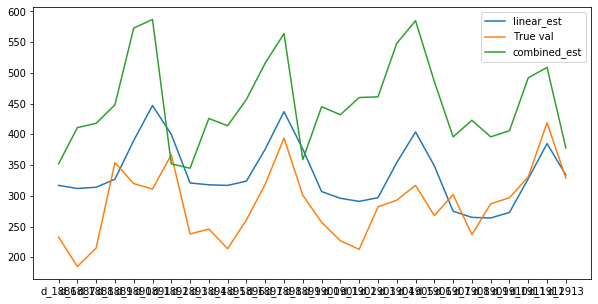

In [419]:
plt.figure(figsize=(10,5))
plt.plot(true_val['linear_estimation'],label='linear_est')
plt.plot(true_val[0],label='True val')
plt.plot(true_val['combined_estimation'],label='combined_est')
plt.legend()
plt.show()

#######################################################################################

In [ ]:
df_test = create_dt(False)
from datetime import timedelta
fday = datetime(2016,4, 25) #d_1914
day = fday + timedelta(days=27)
#Create a dataframe that contains data of the past 57 days
trial = df_test[(df_test.date >= day - timedelta(days=max_lags)) & (df_test.date <= day)]

create_fea(trial)


# Since the ARIMA-ANN hybrid method failed, I'll go ahead and try ANN himself

In [87]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.recurrent import LSTM

In [62]:
FIRST_TRAIN_DAY = 350
f_day = datetime(2011,1,29) + timedelta(days=FIRST_TRAIN_DAY)
last_train_day = datetime(2016,3,27)
first_test_day = datetime(2016,3,28)
record = df_sale_group_item.loc[0]

In [63]:
train_df = record[352:].to_frame()
train_df = train_df.rename({0:'sales'},axis=1)
train_df['date'] = [f_day + timedelta(days=i) for i in range(1913-350)]
train_df.set_index('date',inplace=True)
train_df

,sales
date,
2012-01-14,299
2012-01-15,251
2012-01-16,208
2012-01-17,170
2012-01-18,187
...,...
2016-04-20,287
2016-04-21,297
2016-04-22,331


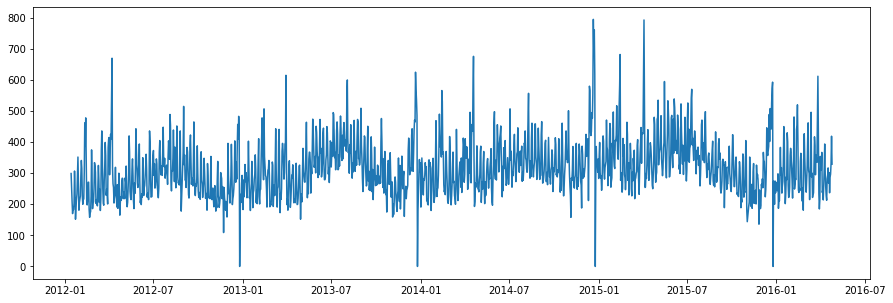

In [64]:
plt.figure(figsize=(15,5))
plt.plot(train_df)
plt.show()

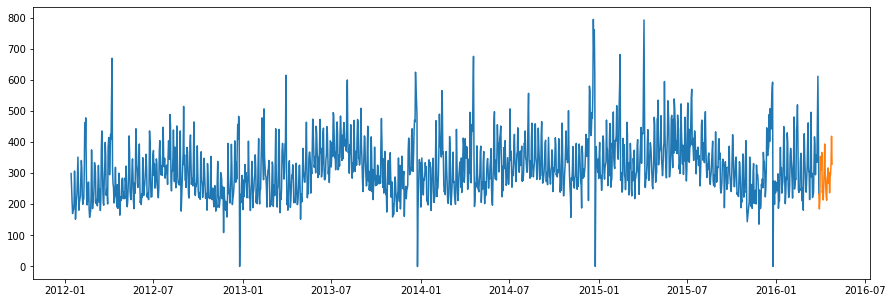

In [65]:
#Train-test-split
train = train_df.loc[:first_test_day]
test = train_df.loc[first_test_day:]
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(test)
plt.show()

In [67]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [81]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [100]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1535/1535 [==============================] - 1s 564us/step - loss: 0.0325
Epoch 2/100
1535/1535 [==============================] - 1s 525us/step - loss: 0.0320
Epoch 3/100
1535/1535 [==============================] - 1s 509us/step - loss: 0.0320
Epoch 4/100
1535/1535 [==============================] - 1s 566us/step - loss: 0.0320
Epoch 5/100
1535/1535 [==============================] - 1s 555us/step - loss: 0.0319
Epoch 6/100
1535/1535 [==============================] - 1s 552us/step - loss: 0.0319
Epoch 7/100
1535/1535 [==============================] - 1s 530us/step - loss: 0.0319
Epoch 8/100
1535/1535 [==============================] - 1s 557us/step - loss: 0.0319 0s - lo
Epoch 00008: early stopping


In [101]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))


The R2 score on the Train set is:	0.364
The R2 score on the Test set is:	0.101


# ANN solution passed. We'll try stl decomposition

In [105]:
import statsmodels.api as sm

In [114]:
rd = sm.tsa.seasonal_decompose(record[2:].to_frame()[0].values, freq=28)#该时间序列周期为72

<Figure size 720x360 with 0 Axes>

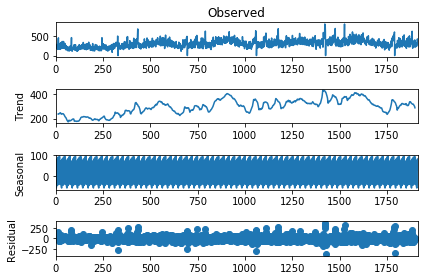

In [119]:
plt.figure(figsize=(10,5))
rd.plot()
plt.show()

# We will also try ARIMA+Random Forest

In [3]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
rand_seed = np.random.randint(len(df_sale_group_item))
record = df_sale_group_item.loc[rand_seed].to_frame()[2:]

fday = datetime(2011,1,29) + timedelta(days=0)
record['sales'] = record[rand_seed]
record.drop(rand_seed,axis=1,inplace=True)
record['date'] = [fday + timedelta(days=i) for i in range(1913)]
record['item_id'] = rand_seed

record['sales'] = record['sales'].astype('float')
record.rename({'date':'timestamp','sales':'demand'},axis=1,inplace=True)

In [36]:
record.set_index('demand',inplace=True)
record

,timestamp,item_id
demand,,
460.0,2011-01-29,16
473.0,2011-01-30,16
363.0,2011-01-31,16
426.0,2011-02-01,16
368.0,2011-02-02,16
...,...,...
439.0,2016-04-20,16
426.0,2016-04-21,16
447.0,2016-04-22,16


In [37]:
record.to_csv('single_record_agg_lvl_9.csv')

In [111]:
preds = pd.Series()
for i in range(50):
    print(f'Iter:{i}\n\n')
    sub_record = record[:513 + i*28]
    arima_model = auto_arima(sub_record['sales'], trace=True,
                              error_action='ignore',   # we don't want to know if an order does not work
                              suppress_warnings=True,  # we don't want convergence warnings
                              stepwise=True)
    result = arima_model.predict(n_periods=28)
    result_series = pd.Series(result)
    preds = pd.concat([preds,result_series],ignore_index=True)

Iter:0


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=6200.195, BIC=6225.625, Time=0.694 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6400.185, BIC=6408.662, Time=0.016 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=6401.755, BIC=6414.470, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6401.377, BIC=6414.092, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=6398.234, BIC=6402.473, Time=0.012 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=6260.086, BIC=6281.278, Time=0.402 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=6235.272, BIC=6256.464, Time=0.556 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=6190.008, BIC=6219.676, Time=1.000 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=6211.703, BIC=6237.133, Time=0.543 seconds
Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=6213.661, BIC=6247.568, Time=1.201 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) 

Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=7161.986, BIC=7210.278, Time=1.750 seconds
Total fit time: 16.024 seconds
Iter:4


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=7631.548, BIC=7658.165, Time=0.673 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7896.015, BIC=7904.887, Time=0.017 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=7897.943, BIC=7911.252, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7897.903, BIC=7911.212, Time=0.060 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=7894.106, BIC=7898.542, Time=0.012 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=7725.405, BIC=7747.586, Time=0.511 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=7689.565, BIC=7711.746, Time=0.361 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=7586.299, BIC=7617.352, Time=0.950 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=7637.175, BIC=7663.792, Time=0.517 seco

Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=9235.905, BIC=9268.114, Time=1.129 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=9277.505, BIC=9305.112, Time=0.581 seconds
Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=9135.171, BIC=9171.980, Time=1.291 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=9231.524, BIC=9263.733, Time=1.011 seconds
Fit ARIMA(5,1,2)x(0,0,0,0) [intercept=True]; AIC=9111.184, BIC=9152.595, Time=1.821 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; AIC=9158.193, BIC=9195.003, Time=0.893 seconds
Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=9096.918, BIC=9142.930, Time=1.780 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=9079.918, BIC=9121.329, Time=1.493 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=9091.157, BIC=9127.966, Time=1.333 seconds
Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=9084.587, BIC=9130.599, Time=1.659 seconds
Fit ARIMA(3,1,4)x(0,0,0,0) [intercept=True]; AIC=9102.383, BIC=9143.794, Time=1.

Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=10612.136, BIC=10650.079, Time=1.622 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=10713.997, BIC=10747.197, Time=0.983 seconds
Fit ARIMA(5,1,2)x(0,0,0,0) [intercept=True]; AIC=10566.183, BIC=10608.869, Time=1.802 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; AIC=10631.121, BIC=10669.064, Time=0.908 seconds
Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=10551.676, BIC=10599.105, Time=2.078 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=10538.867, BIC=10581.552, Time=1.677 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=10551.162, BIC=10589.105, Time=1.539 seconds
Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=10545.465, BIC=10592.894, Time=1.982 seconds
Fit ARIMA(3,1,4)x(0,0,0,0) [intercept=True]; AIC=10564.057, BIC=10606.743, Time=1.809 seconds
Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=10544.421, BIC=10596.593, Time=2.444 seconds
Total fit time: 21.002 seconds
Iter:13


Performing stepwise

Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=11952.354, BIC=12001.023, Time=2.615 seconds
Fit ARIMA(3,1,4)x(0,0,0,0) [intercept=True]; AIC=11974.266, BIC=12018.068, Time=2.817 seconds
Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=11941.119, BIC=11994.655, Time=3.077 seconds
Fit ARIMA(5,1,5)x(0,0,0,0) [intercept=True]; AIC=11875.110, BIC=11933.513, Time=4.095 seconds
Fit ARIMA(4,1,5)x(0,0,0,0) [intercept=True]; AIC=11888.979, BIC=11942.516, Time=3.537 seconds
Total fit time: 37.358 seconds
Iter:17


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=12571.303, BIC=12600.677, Time=1.289 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13065.402, BIC=13075.194, Time=0.026 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=13066.923, BIC=13081.610, Time=0.051 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13066.582, BIC=13081.269, Time=0.094 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=13063.448, BIC=13068

Fit ARIMA(4,1,5)x(0,0,0,0) [intercept=True]; AIC=13367.229, BIC=13421.979, Time=3.440 seconds
Total fit time: 37.425 seconds
Iter:21


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=14100.336, BIC=14130.354, Time=1.348 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14675.508, BIC=14685.514, Time=0.029 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=14676.810, BIC=14691.820, Time=0.058 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14676.267, BIC=14691.276, Time=0.109 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=14673.536, BIC=14678.539, Time=0.016 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=14315.417, BIC=14340.433, Time=1.055 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=14236.344, BIC=14261.359, Time=0.882 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=14058.864, BIC=14093.886, Time=1.739 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=14137.643, BIC=14167

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=15547.302, BIC=15577.902, Time=1.312 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16191.718, BIC=16201.918, Time=0.027 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=16193.486, BIC=16208.786, Time=0.069 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16193.311, BIC=16208.611, Time=0.126 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=16189.732, BIC=16194.832, Time=0.018 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=15789.729, BIC=15815.229, Time=1.247 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=15697.818, BIC=15723.319, Time=0.781 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=15504.821, BIC=15540.521, Time=1.805 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=15588.692, BIC=15619.292, Time=1.187 seconds
Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=15313.697, BIC=15354.497, Time=2.329 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=15490.000,

Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=16264.276, BIC=16315.946, Time=2.883 seconds
Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=16260.902, BIC=16317.740, Time=3.024 seconds
Fit ARIMA(5,1,5)x(0,0,0,0) [intercept=True]; AIC=16131.121, BIC=16193.125, Time=3.615 seconds
Fit ARIMA(4,1,5)x(0,0,0,0) [intercept=True]; AIC=16149.775, BIC=16206.612, Time=3.548 seconds
Total fit time: 41.055 seconds
Iter:29


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=16984.005, BIC=17015.135, Time=1.316 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17708.934, BIC=17719.310, Time=0.027 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=17710.918, BIC=17726.483, Time=0.053 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17710.906, BIC=17726.471, Time=0.098 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=17706.967, BIC=17712.155, Time=0.013 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=17264.291, BIC=17290

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=19355.617, BIC=19360.886, Time=0.015 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=18864.540, BIC=18890.888, Time=0.936 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=18742.300, BIC=18768.649, Time=1.202 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=18528.494, BIC=18565.381, Time=1.756 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=18622.424, BIC=18654.041, Time=1.181 seconds
Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=18254.415, BIC=18296.572, Time=2.494 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=18488.701, BIC=18525.588, Time=1.540 seconds
Fit ARIMA(5,1,2)x(0,0,0,0) [intercept=True]; AIC=18170.762, BIC=18218.188, Time=2.796 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; AIC=18321.907, BIC=18364.064, Time=1.617 seconds
Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=18174.378, BIC=18227.074, Time=3.025 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=18140.795,

Fit ARIMA(5,1,2)x(0,0,0,0) [intercept=True]; AIC=19651.096, BIC=19699.198, Time=2.803 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; AIC=19832.083, BIC=19874.841, Time=1.715 seconds
Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=19644.961, BIC=19698.409, Time=3.248 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=19629.278, BIC=19677.381, Time=2.752 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=19700.231, BIC=19742.989, Time=2.510 seconds
Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=19632.769, BIC=19686.216, Time=3.114 seconds
Fit ARIMA(3,1,4)x(0,0,0,0) [intercept=True]; AIC=19705.827, BIC=19753.929, Time=3.010 seconds
Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=19669.299, BIC=19728.091, Time=3.429 seconds
Total fit time: 34.002 seconds
Iter:38


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=20485.147, BIC=20517.323, Time=1.517 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=21367.255, BIC=21377.

Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=21521.905, BIC=21559.807, Time=1.862 seconds
Fit ARIMA(5,1,2)x(0,0,0,0) [intercept=True]; AIC=21120.269, BIC=21169.000, Time=2.984 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; AIC=21323.551, BIC=21366.867, Time=2.523 seconds
Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=21125.409, BIC=21179.555, Time=3.382 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=21098.038, BIC=21146.769, Time=2.785 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=21158.923, BIC=21202.240, Time=2.853 seconds
Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=21098.045, BIC=21152.190, Time=3.557 seconds
Fit ARIMA(3,1,4)x(0,0,0,0) [intercept=True]; AIC=21168.678, BIC=21217.409, Time=3.146 seconds
Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=21153.472, BIC=21213.032, Time=3.588 seconds
Total fit time: 37.100 seconds
Iter:42


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=22007.570, BIC=22040.

Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; AIC=22843.020, BIC=22886.859, Time=1.968 seconds
Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=22622.757, BIC=22677.555, Time=3.524 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=22626.179, BIC=22675.498, Time=2.793 seconds
Total fit time: 24.748 seconds
Iter:46


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=23581.912, BIC=23614.885, Time=1.590 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=24569.777, BIC=24580.768, Time=0.037 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=24571.704, BIC=24588.190, Time=0.076 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=24571.641, BIC=24588.128, Time=0.134 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=24567.789, BIC=24573.285, Time=0.018 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=23948.069, BIC=23975.546, Time=1.055 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=23798.978, BIC=23826

Fit ARIMA(5,1,3)x(0,0,0,0) [intercept=True]; AIC=24141.337, BIC=24196.749, Time=3.888 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=24130.309, BIC=24180.179, Time=3.173 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=24221.994, BIC=24266.323, Time=3.219 seconds
Fit ARIMA(4,1,4)x(0,0,0,0) [intercept=True]; AIC=24121.168, BIC=24176.579, Time=4.111 seconds
Fit ARIMA(3,1,4)x(0,0,0,0) [intercept=True]; AIC=24211.076, BIC=24260.947, Time=3.549 seconds
Fit ARIMA(5,1,4)x(0,0,0,0) [intercept=True]; AIC=24117.413, BIC=24178.365, Time=4.360 seconds
Fit ARIMA(5,1,5)x(0,0,0,0) [intercept=True]; AIC=23834.871, BIC=23901.365, Time=5.573 seconds
Fit ARIMA(4,1,5)x(0,0,0,0) [intercept=True]; AIC=23875.947, BIC=23936.900, Time=4.958 seconds
Total fit time: 52.817 seconds


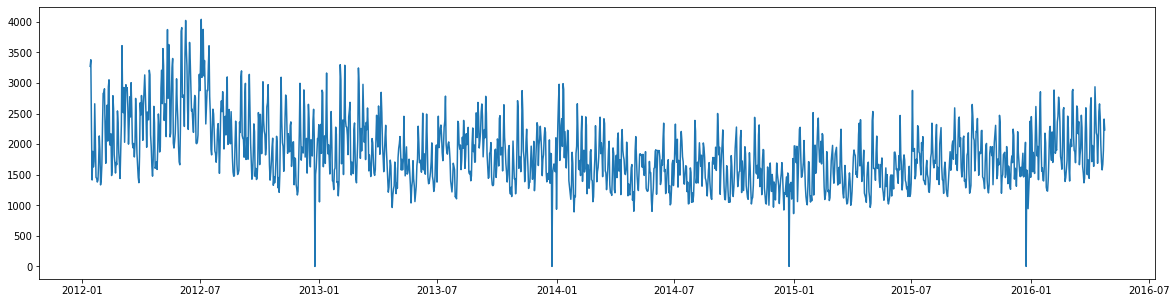

In [59]:
plt.figure(figsize=(20,5))
plt.plot(record)
plt.show()

In [93]:
(1913-513)/28

50.0